# Analysis of the MCMC fit of exponential disk to LMC data

In [1]:
import numpy as np
import getdist
from getdist import MCSamples, plots
from getdist.chains import Chains
import matplotlib as mpl
import matplotlib.pyplot as plt 
from modules import potential_tools as pt
import copy
import matplotlib as mpl

In [2]:
mpl.rcParams['axes.labelsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'xx-large'
mpl.rcParams['ytick.labelsize'] = 'xx-large'

## Chains

In [3]:
samples = np.loadtxt('./chains/mcmc_exp_profile.txt')

## Contours

In [4]:
getdist_samples = MCSamples(samples = samples, names = ['a', 'b', 'logM'])

Removed no burn in


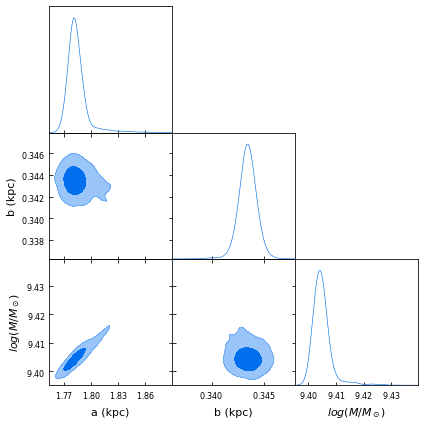

In [5]:
g = plots.get_subplot_plotter()
g.triangle_plot(getdist_samples, filled = True)

ax_a_b = g.get_axes_for_params('a', 'b')
ax_a_b.set_ylabel('b (kpc)')

ax_a_logM = g.get_axes_for_params('a', 'logM')
ax_a_logM.set_xlabel('a (kpc)')
ax_a_logM.set_ylabel(r'$log(M/M_\odot)$')

ax_b_logM = g.get_axes_for_params('b', 'logM')
ax_b_logM.set_xlabel('b (kpc)')

ax_logM_logM = g.get_axes_for_params('logM')
ax_logM_logM.set_xlabel(r'$log(M/M_\odot)$')

plt.savefig('./figures/exp_contours.pdf', bbox_inches = 'tight')


plt.show()

## Statistics

In [6]:
mean = getdist_samples.getMeans()
#np.savetxt('./results/mean_exp_fit_params.txt', mean)

In [7]:
std = np.sqrt(getdist_samples.getVars())
#np.savetxt('./results/std_exp_fit_params.txt', std)

## Exp density and its verification with data

In [8]:
nsamples = len(samples)

In [9]:
Rvals = np.round(np.load('./data/x_vals.npy'), 2)
zvals = np.round(np.load('./data/z_vals.npy'), 2)

In [10]:
rho_data = np.load('./data/2d_density.npy')
rho_error_data = np.load('./data/error_2d_density.npy')

In [11]:
H_chain = samples[:, 0]
z0_chain = samples[:, 1]
logM_chain = samples[:, 2]

In [12]:
Nchains = len(samples)

### Radial densities

In [13]:
getdist_samples_rad = copy.deepcopy(getdist_samples)

In [14]:
z_at = 0.05
zidx = np.where(zvals == z_at)[0]

In [15]:
for ridx in range(len(Rvals)):
    radial_rho_exp = pt.exp_rho(np.full(Nchains, Rvals[ridx]), np.full(Nchains, z_at), H_chain, z0_chain, logM_chain)
    getdist_samples_rad.addDerived(radial_rho_exp, name = 'exp_density_rad'+ str(Rvals[ridx]))

In [16]:
mean_exp_rho_rad = getdist_samples_rad.getMeans()[3:]
std_exp_rho_rad = np.sqrt(getdist_samples_rad.getVars()[3:])

#### Verifying with radial data

In [17]:
radial_rho_data = rho_data[:, zidx].reshape(len(Rvals), )
radial_rho_error_data = rho_error_data[:, zidx].reshape(len(Rvals), )

In [18]:
log_radial_res, log_radial_res_error = pt.get_fit_residual(np.log10(radial_rho_data), np.log10(mean_exp_rho_rad),
                                                          radial_rho_error_data/(np.log(10)*radial_rho_data),
                                                          std_exp_rho_rad/(np.log(10)*mean_exp_rho_rad))

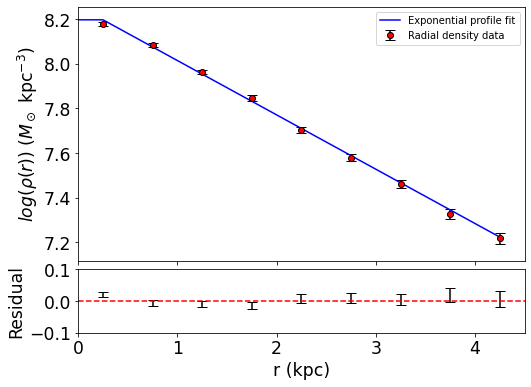

In [19]:
fig = plt.figure(figsize = (8,6))

gs = fig.add_gridspec(2, 1, height_ratios = (4, 1), hspace = 0.05)

ax0 = fig.add_subplot(gs[0, 0])
ax0.errorbar(Rvals, np.log10(radial_rho_data), yerr = radial_rho_error_data/(radial_rho_data*np.log(10)),
             ecolor = 'black', capsize = 5, fmt = 'o', color = 'r', markeredgecolor = 'black',
            label = 'Radial density data')
ax0.plot(Rvals, np.log10(mean_exp_rho_rad), color = 'blue', label = 'Exponential profile fit')
#ax0.fill_between(Rvals, np.log10(mean_exp_rho_rad - std_exp_rho_rad), 
#                 np.log10(mean_exp_rho_rad + std_exp_rho_rad), 
#                 color = 'cyan', label = '1 sigma band of exp fit')
ax0.set_xlim(0, 4.5)
ax0.set_xticklabels([])
ax0.set_ylabel(r'$log(\rho(r))$ ($M_\odot$ kpc$^{-3}$)')
ax0.legend()
#ax0.set_title('Radial Densities')

ax1 = fig.add_subplot(gs[1, 0])
ax1.errorbar(Rvals, log_radial_res, yerr = log_radial_res_error, ecolor = 'black', capsize = 5, color = 'black'
            , fmt = 'o', markersize = 0)
ax1.set_ylim(-0.1, 0.1)
ax1.hlines(0, 0, 4.5, color = 'r', linestyles = 'dashed')
ax1.set_xlim(0, 4.5)
ax1.set_xlabel('r (kpc)')
ax1.set_ylabel('Residual')

plt.savefig('./figures/exp_fit_radial.pdf', bbox_inches = 'tight')
plt.show()

### Vertical densities

In [20]:
getdist_samples_vert = copy.deepcopy(getdist_samples)

In [21]:
R_at = 0.25
Ridx = np.where(Rvals == R_at)[0]

In [22]:
for zidx in range(len(zvals)):
    vert_rho_exp = pt.exp_rho(np.full(Nchains, R_at), np.full(Nchains, zvals[zidx]), H_chain, z0_chain, logM_chain)
    getdist_samples_vert.addDerived(vert_rho_exp, name = 'exp_density_vert'+ str(zvals[zidx]))

In [23]:
mean_exp_rho_vert = getdist_samples_vert.getMeans()[3:]
std_exp_rho_vert = np.sqrt(getdist_samples_vert.getVars()[3:])

#### Verifiying with vertical data

In [24]:
vert_rho_data = rho_data[Ridx, :].reshape(len(zvals), )
vert_rho_error_data = rho_error_data[Ridx, :].reshape(len(zvals), )

In [25]:
log_vert_res, log_vert_res_error = pt.get_fit_residual(np.log10(vert_rho_data), np.log10(mean_exp_rho_vert),
                                                          vert_rho_error_data/(np.log(10)*vert_rho_data),
                                                          std_exp_rho_vert/(np.log(10)*mean_exp_rho_vert))

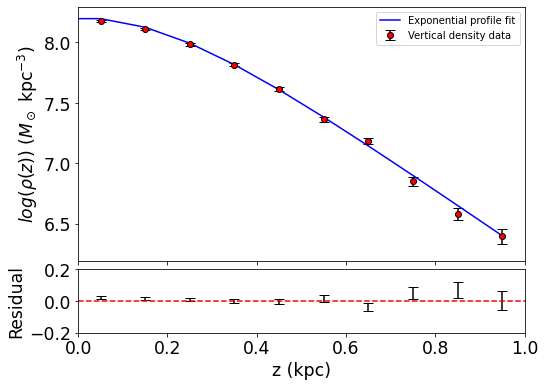

In [28]:
fig = plt.figure(figsize = (8,6))

gs = fig.add_gridspec(2, 1, height_ratios = (4, 1), hspace = 0.05)

ax0 = fig.add_subplot(gs[0, 0])
ax0.errorbar(zvals, np.log10(vert_rho_data), yerr = vert_rho_error_data/(vert_rho_data*np.log(10)),
             ecolor = 'black', capsize = 5, fmt = 'o', color = 'r', markeredgecolor = 'black',
            label = 'Vertical density data')
ax0.plot(zvals, np.log10(mean_exp_rho_vert), color = 'blue', label = 'Exponential profile fit')
#ax0.fill_between(zvals, np.log10(mean_exp_rho_vert - std_exp_rho_vert), 
#                 np.log10(mean_exp_rho_vert + std_exp_rho_vert), 
#                 color = 'cyan', label = '1 sigma band of exp fit')
ax0.set_xlim(0, 1)
ax0.set_xticklabels([])
ax0.set_ylabel(r'$log(\rho(z))$ ($M_\odot$ kpc$^{-3}$)')
ax0.legend()
#ax0.set_title('Vertical Densities')

ax1 = fig.add_subplot(gs[1, 0])
ax1.errorbar(zvals, log_vert_res, yerr = log_vert_res_error, ecolor = 'black', capsize = 5, color = 'black'
            , fmt = 'o', markersize = 0)
ax1.set_ylim(-0.2, 0.2)
ax1.hlines(0, 0, 1, color = 'r', linestyles = 'dashed')
ax1.set_xlim(0, 1)
ax1.set_xlabel('z (kpc)')
ax1.set_ylabel('Residual')

plt.savefig('./figures/exp_fit_vertical.pdf', bbox_inches = 'tight')
plt.show()